# PPAC Analysis Notebook

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import sys
sys.modules['numpy._core.numeric']    = np.core.numeric
sys.modules['numpy._core.multiarray'] = np.core.multiarray

## Load Data

In [51]:
# data_dir = 'correlations/all_isobutane_1_hit_square'
data_dir = 'correlations/r52_test_1nsbox'
data_paths = {
    "coincident": Path(f"{data_dir}/coincident_imp.pkl"),
    "decay_candidates": Path(f"{data_dir}/decay_candidates.pkl"),
    "final_correlated": Path(f"{data_dir}/final_correlated.pkl"),
}
data = {}
for name, path in data_paths.items():
    if path.exists():
        data[name] = pd.read_pickle(path)
        print(f"Loaded {name}: {len(data[name])} rows")
    else:
        print(f"File {path} not found")
        
        
decays = data["decay_candidates"]    
coincident = data["coincident"]  
df = data["final_correlated"]
df_RA = df[df['chain']=='RA']
df_RE = df[df['chain']=='RE']
df_RAA = df[df['chain']=='RAA']
df_REA = df[df['chain']=='REA']
df_REAA = df[df['chain']=='REAA']

Loaded coincident: 41382 rows
Loaded decay_candidates: 3920972 rows
Loaded final_correlated: 284 rows


['timetag', 'x', 'y', 'imp_tagx', 'imp_tagy', 'imp_nfile', 'imp_tdelta', 'imp_nX', 'imp_nY', 'xE', 'imp_yE', 'xboard', 'yboard', 'cathode_timetag', 'cathode_energy', 'anodeV_timetag', 'anodeV_energy', 'anodeH_timetag', 'anodeH_energy', 'dt_cathode_ps', 'dt_anodeV_ps', 'dt_anodeH_ps', 'dt_cathode_ns', 'dt_anodeV_ns', 'dt_anodeH_ns', 'num_hits', 'dt_cathode_us', 'dt_anodeV_us', 'dt_anodeH_us']


(0.0, 50000.0)

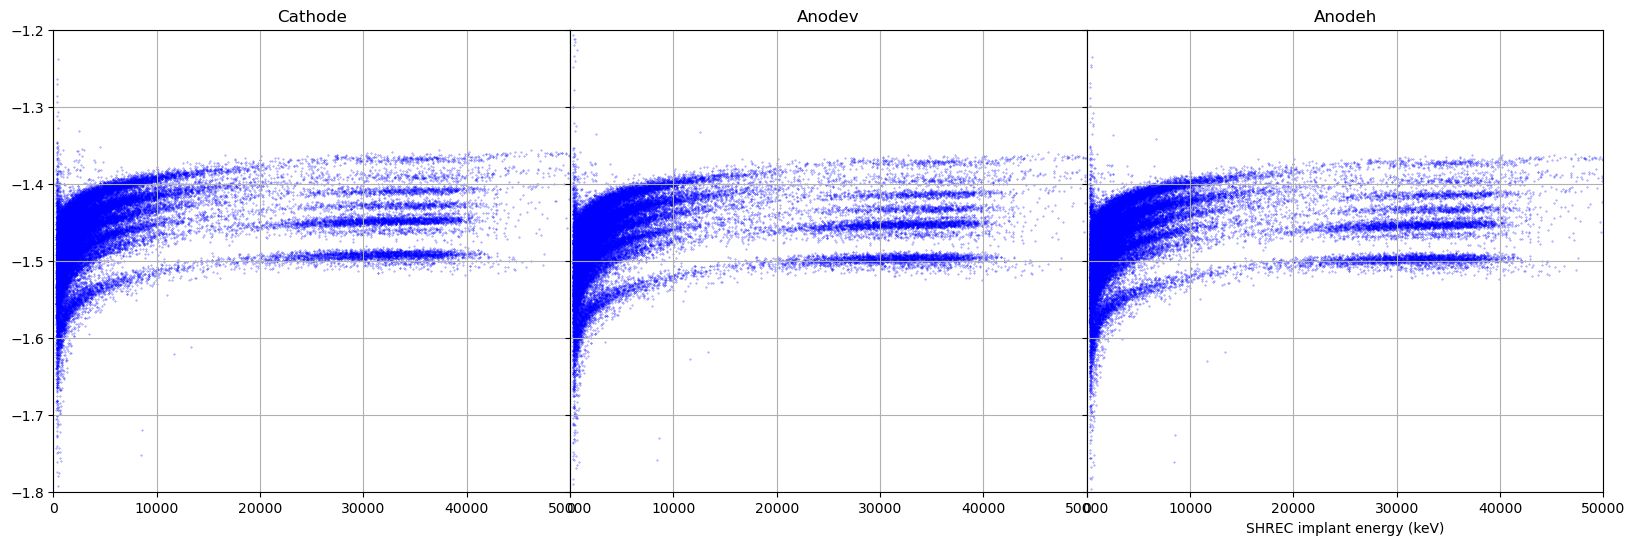

In [78]:
cols = coincident.columns.tolist()
print(cols)

plates = ['cathode', 'anodeV', 'anodeH']
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0)
for ax, plate in zip(axs, plates):

    imp_col = f'dt_{plate}_us'
    rec_col = f'rec_dt_{plate}_us'
#     hb = ax.hexbin(
#         coincident['xE'], coincident[imp_col],gridsize=200, extent=(0, 10000, -1.7, -1.5), 
#         mincnt=1, cmap='viridis', alpha=0.7
#     )
    # or scatter
    ax.scatter(coincident['xE'], coincident[imp_col], 
                alpha=0.6, s=0.1, c='blue')
#     ax.set_ylabel(f'ToF μs ({plate})')
    ax.set_title(f'{plate.capitalize()}')
    ax.tick_params(axis='both', which='major')
    ax.set_ylim(-1.8,-1.2)
    ax.grid()

axs[-1].set_xlabel('SHREC implant energy (keV)')
plt.xlim(0,50e3)
# plt.grid()

In [49]:
print(df_RA.columns.tolist())

['recoil_x', 'recoil_y', 'recoil_xE', 'timetag', 'cathode_timetag', 'cathode_energy', 'anodeV_timetag', 'anodeV_energy', 'anodeH_timetag', 'anodeH_energy', 'recoil_t', 'alpha1_x', 'alpha1_y', 'alpha1_t', 'alpha1_xE', 'alpha1_dt', 'chain', 'electron1_x', 'electron1_y', 'electron1_t', 'electron1_xE', 'electron1_dt', 'alpha2_x', 'alpha2_y', 'alpha2_t', 'alpha2_xE', 'alpha2_dt']


In [50]:
display(df_RA)

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,electron1_x,electron1_y,electron1_t,electron1_xE,electron1_dt,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt
0,6.0,54.0,5655.067523,1.840337e+13,1.840337e+13,4633.0,1.840337e+13,1562.0,1.840337e+13,1305.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33.0,6.0,2758.829675,4.590237e+13,4.590237e+13,3209.0,4.590237e+13,773.0,4.590237e+13,921.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,62.0,45.0,7737.031594,8.068357e+13,8.068357e+13,3869.0,8.068357e+13,724.0,8.068357e+13,2055.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,112.0,21.0,5473.134474,8.096330e+13,8.096330e+13,3063.0,8.096330e+13,436.0,8.096330e+13,1281.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19.0,17.0,6421.242105,1.089485e+14,1.089485e+14,5069.0,1.089485e+14,920.0,1.089485e+14,2420.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,59.0,26.0,7873.073319,7.430202e+15,7.430202e+15,2955.0,7.430202e+15,929.0,7.430202e+15,692.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,40.0,26.0,5496.280774,7.469306e+15,7.469306e+15,4013.0,7.469306e+15,1235.0,7.469306e+15,956.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,98.0,35.0,7037.067830,7.493492e+15,7.493492e+15,3648.0,7.493492e+15,1039.0,7.493492e+15,1112.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,38.0,23.0,6937.207514,7.510715e+15,7.510715e+15,3878.0,7.510715e+15,1600.0,7.510715e+15,613.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# all energies


Text(0, 0.5, 'Counts/ 10keV')

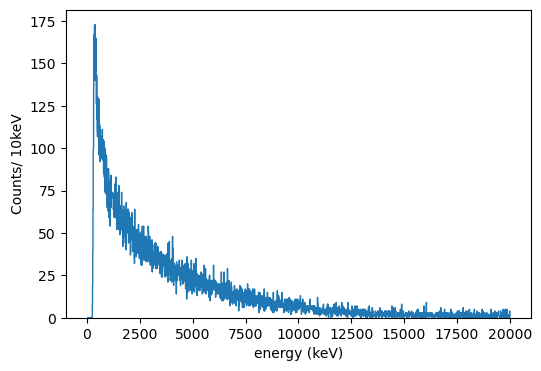

In [7]:
plt.figure(figsize=(6,4))

plt.hist(coincident['xE'], histtype='step', bins=2000, range=(0,20000)) #10keV
# plt.hist(decays['xE'], histtype='step', bins=5000, range=(0,50000))
plt.xlabel('energy (keV)')
plt.ylabel(r'Counts/ 10keV')
# plt.xlim(5e3,15e3)
# plt.xlim(4e3,10e3)
# plt.ylim(bottom=0,top=800)
# plt.yscale('log')

# RA

Text(0, 0.5, 'Counts/ 40keV')

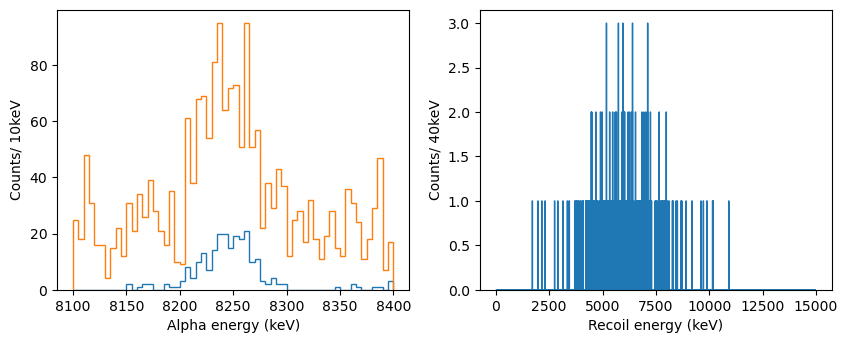

In [8]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RA['alpha1_xE'], histtype='step', bins=60, range=(8100,8400))
plt.hist(decays['xE'], histtype='step', bins=60, range=(8100,8400))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')

plt.subplot(222)
plt.hist(df_RA['recoil_xE'], histtype='step',bins=1500, range=(0,15e3))
plt.xlabel('Recoil energy (keV)')
plt.ylabel(r'Counts/ 40keV')

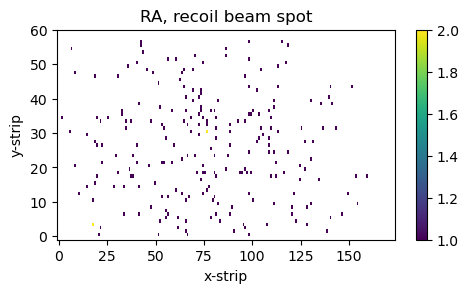

In [14]:
# # correlated beam spot
plt.figure(figsize=(12,6))
# plt.subplots_adjust(hpsace=0.3)
plt.subplot(221)
plt.hist2d(df_RA['recoil_x'], df_RA['recoil_y'], 
           bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
plt.xlabel('x-strip')
plt.ylabel(r'y-strip')
plt.title(r'RA, recoil beam spot')
plt.colorbar()


# plt.subplot(222)
# plt.hist2d(coincident['recoil_x'], coincident['recoil_y'], 
#            bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
# # plt.xlim(0, 10000)
# plt.xlabel('x-strip')
# plt.ylabel(r'y-strip')
# plt.title(r'Uncorrelated recoil beam spot')
# plt.colorbar()

# plt.subplot(223)
# plt.hist2d(df_RAA['x'], df_RAA['y'], 
#            bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
# plt.xlabel('x-strip')
# plt.ylabel(r'y-strip')
# plt.title(r'RAA, recoil beam spot')
# plt.colorbar()

# plt.subplot(224)
# plt.hist2d(df_REAA['x'], df_REAA['y'], 
#            bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
# plt.xlabel('x-strip')
# plt.ylabel(r'y-strip')
# plt.title(r'RAA, recoil beam spot')
# plt.colorbar()





# RAA

In [15]:
df_RAA = df[df['chain']=='RAA']
display(df_RAA)

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha1_y,alpha1_t,alpha1_xE,alpha1_dt,chain,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt
226,78.0,36.0,6818.471753,3.565413e+14,3.565413e+14,4025.0,3.565413e+14,1079.0,3.565413e+14,1465.0,...,36.0,360.992281,8227.502927,4.450984,RAA,78.0,36.0,488.930251,7418.395390,127.937969
227,41.0,6.0,8714.106939,3.594965e+14,3.594965e+14,4349.0,3.594965e+14,944.0,3.594965e+14,1810.0,...,6.0,360.483475,8232.303576,0.986944,RAA,41.0,6.0,398.142254,7408.061461,37.658779
228,46.0,20.0,6196.344472,5.342252e+14,5.342252e+14,3397.0,5.342252e+14,740.0,5.342252e+14,1123.0,...,20.0,535.168024,8223.327221,0.942819,RAA,46.0,20.0,542.226971,7404.163101,7.058947
229,128.0,3.0,7113.358653,6.342515e+14,6.342515e+14,4060.0,6.342515e+14,1170.0,6.342515e+14,1306.0,...,3.0,635.695391,8257.311702,1.443897,RAA,128.0,3.0,805.639610,7422.044397,169.944220
230,25.0,34.0,7088.708327,7.139576e+14,7.139576e+14,2159.0,7.139576e+14,1027.0,7.139576e+14,175.0,...,34.0,714.041050,8204.750629,0.083489,RAA,25.0,34.0,1134.633620,7374.026968,420.592570
231,40.0,21.0,6734.285041,7.483443e+14,7.483443e+14,4724.0,7.483443e+14,1221.0,7.483443e+14,1788.0,...,21.0,749.350743,8207.353409,1.006449,RAA,40.0,21.0,1477.370023,7386.587922,728.019280
232,51.0,44.0,4683.131066,1.035592e+15,1.035592e+15,4270.0,1.035592e+15,899.0,1.035592e+15,1769.0,...,44.0,1036.654706,8257.541600,1.062733,RAA,51.0,44.0,1609.949653,7400.798830,573.294947
233,21.0,2.0,4326.123686,1.379051e+15,1.379051e+15,4152.0,1.379051e+15,822.0,1.379051e+15,1702.0,...,2.0,1384.304350,8208.917372,5.253422,RAA,21.0,2.0,1693.631455,7390.869106,309.327104
234,72.0,40.0,9723.252356,1.440706e+15,1.440706e+15,3259.0,1.440706e+15,775.0,1.440706e+15,1117.0,...,40.0,1442.347938,8218.253968,1.642040,RAA,72.0,40.0,1470.120498,7387.224475,27.772560
235,64.0,48.0,6348.183124,1.621792e+15,1.621792e+15,3318.0,1.621792e+15,1077.0,1.621792e+15,798.0,...,48.0,1622.046220,8264.911364,0.253826,RAA,64.0,48.0,1687.986596,7430.078585,65.940375


(0.0, 10000.0)

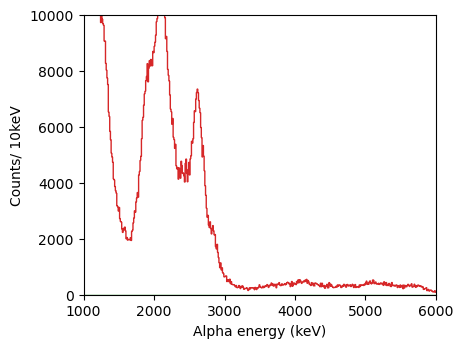

In [67]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RAA['alpha1_xE'], histtype='step', bins=60, range=(8100,8400))
plt.hist(df_RAA['alpha2_xE'], histtype='step', bins=60, range=(7250,7550))
plt.hist(df_RAA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
plt.hist(decays['xE'], histtype='step', bins=1000, range=(0,10e3))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')
plt.xlim(1e3,6e3)
# plt.xlim(0,700)
plt.ylim(top=10e3)


# REAA

In [23]:
df_REAA = df[df['chain']=='REAA']
display(df_REAA)

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha1_y,alpha1_t,alpha1_xE,alpha1_dt,chain,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt


Text(0, 0.5, 'Counts/ 10keV')

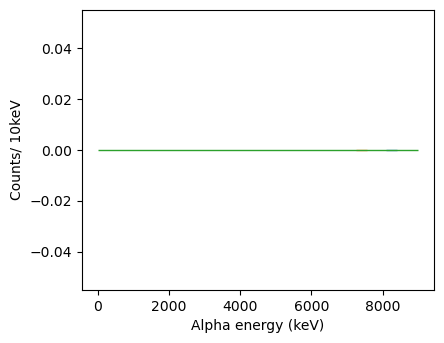

In [24]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_REAA['alpha1_xE'], histtype='step', bins=60, range=(8100,8400))
plt.hist(df_REAA['alpha2_xE'], histtype='step', bins=60, range=(7250,7550))
plt.hist(df_REAA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')

# Decay KHS

Text(0, 0.5, 'Ln($\\Delta$t/ s)/ 10 keV')

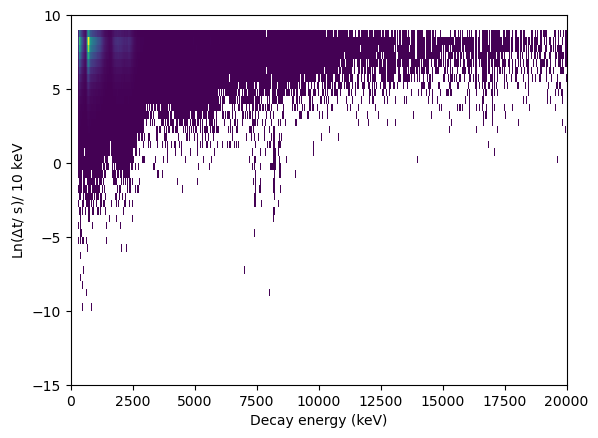

In [68]:
plt.figure()
plt.hist2d(decays['yE'], decays['log_dt'], 
           bins=((1000),(50)), range=((0,20e3),(-15,10)), cmin=1)
plt.xlabel('Decay energy (keV)')
plt.ylabel(r'Ln($\Delta$t/ s)/ 10 keV')




# electron half-life

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Conversion factors for displaying half-life in different units
_UNIT_CONVERSION = {
    's': 1,       # seconds
    'ms': 1e3,    # milliseconds
    'us': 1e6,    # microseconds
    'min': 1/60,  # minutes
    'h': 1/3600   # hours
}


def fit_log_dt_decay(df, t1_col, t2_col, initial_guess,
                     bins=50, hist_range=(-10, 3), num_theta=500,
                     bounds=([0, 0], [np.inf, np.inf]), ax=None,
                     color=None, display_unit='s',
                     plot_data_kwargs=None, plot_fit_kwargs=None):
    # Validate display_unit
    if display_unit not in _UNIT_CONVERSION:
        raise ValueError(f"Unsupported display_unit '{display_unit}'. "
                         f"Choose from {list(_UNIT_CONVERSION.keys())}.")

    # 1. Compute log(dt) and histogram
    log_dt = np.log(df[t1_col] - df[t2_col])
    hist, edges = np.histogram(log_dt, bins=bins, range=hist_range)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # 2. Mask zero-count bins
    mask = hist > 0
    x = centers[mask]
    y = hist[mask]

    # 3. Define model PDF in theta = ln(dt)
    def _pdf(theta, lam, n0):
        dt = np.exp(theta)
        return n0 * lam * dt * np.exp(-lam * dt)

    # 4. Curve fitting
    popt, pcov = curve_fit(_pdf, x, y, p0=initial_guess, bounds=bounds)
    lam_fit, n0_fit = popt
    lam_err = np.sqrt(np.diag(pcov))[0]

    # 5. Compute half-life and error in seconds
    t_half_sec = np.log(2) / lam_fit
    t_half_err_sec = (np.log(2) / lam_fit**2) * lam_err

    # 6. Convert to desired display unit
    factor = _UNIT_CONVERSION[display_unit]
    t_half_disp = t_half_sec * factor
    t_half_err_disp = t_half_err_sec * factor

    # 7. Build smooth fitted curve
    theta_fit = np.linspace(edges.min(), edges.max(), num_theta)
    fit_curve = _pdf(theta_fit, lam_fit, n0_fit)

    result = {
        'bin_centres': centers,
        'hist': hist,
        'fit_mask': mask,
        'fit_bin_centres': x,
        'popt': popt,
        'pcov': pcov,
        't_half_sec': t_half_sec,
        't_half_err_sec': t_half_err_sec,
        't_half_disp': t_half_disp,
        't_half_err_disp': t_half_err_disp,
        'disp_unit': display_unit,
        'theta_fit': theta_fit,
        'fit_curve': fit_curve,
    }

    # 8. Optional plotting
    if ax is not None:
        # Default plotting kwargs
        pdkw = {'fmt': 'o', 'yerr': np.sqrt(hist + 1), 'capsize': 2, 'ms': 4}
        pfkw = {'lw': 2}
        if color is not None:
            pdkw['color'] = color
            pfkw['color'] = color
        if plot_data_kwargs:
            pdkw.update(plot_data_kwargs)
        if plot_fit_kwargs:
            pfkw.update(plot_fit_kwargs)

        # Plot histogram and fit
        ax.errorbar(centers, hist, alpha=0.3, **pdkw)
        ax.step(centers, hist, where='mid', alpha=0.6,
                color=color if color is not None else pdkw.get('color'))
        unit_label = display_unit
        ax.plot(theta_fit, fit_curve, **pfkw,
                label=f"T₁/₂ = {t_half_disp:.2f} ± {t_half_err_disp:.2f} {unit_label}")

    return result


def plot_multiple_decay_fits(datasets, figsize=(6,4),
                             bins=50, hist_range=(-10, 3),
                             num_theta=500, bounds=([0, 0], [np.inf, np.inf]),
                             display_unit='s'):

    if display_unit not in _UNIT_CONVERSION:
        raise ValueError(f"Unsupported display_unit '{display_unit}'. "
                         f"Choose from {list(_UNIT_CONVERSION.keys())}.")

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel('log(dt / s)')
    ax.set_ylabel('Counts')

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for idx, data in enumerate(datasets):
        color = colors[idx % len(colors)]
        res = fit_log_dt_decay(
            df=data['df'],
            t1_col=data['t1_col'],
            t2_col=data['t2_col'],
            initial_guess=data['initial'],
            bins=bins,
            hist_range=hist_range,
            num_theta=num_theta,
            bounds=bounds,
            ax=ax,
            color=color,
            display_unit=display_unit,
            plot_data_kwargs={'label': data.get('label')},
            plot_fit_kwargs={'linestyle': data.get('linestyle', '-')}
        )

    ax.legend(title=f"T₁/₂ [{display_unit}]")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    return fig, ax


# Electron half life

In [30]:
# # # Define your list of data‐settings:
# fm246_isomer = [
#     {
#       'df': df_REA,
#       't1_col': 'electron1_t',
#       't2_col': 'recoil_t',
#       'initial': [np.log(2)/1.0, 100],  
#       'label': 'REA',
#       'linestyle': '-'                   
#     },
#     {
#       'df': df_REAA,
#       't1_col': 'electron1_t',
#       't2_col': 'recoil_t',
#       'initial': [np.log(2)/1, 20],
#       'label': 'REAA',
#       'linestyle': '--'
#     },

# ]

# fig, ax = plot_multiple_decay_fits(fm246_isomer,
#                                    bins=60,
#                                    hist_range=(-8,4))
# plt.title("246Fm isomer (?) half-life")
# plt.ylim(bottom=0)
# plt.show()


# 246 Fm half life

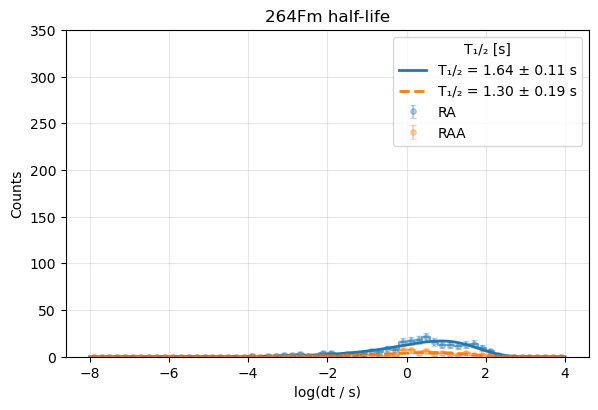

In [28]:
# # Define your list of data‐settings:
fm246 = [
    {
      'df': df_RA,
      't1_col': 'alpha1_t',
      't2_col': 'recoil_t',
      'initial': [np.log(2)/1.5, 100],   # lambda guess, n0 guess
      'label': 'RA',
      'linestyle': '-'                   
    },
    {
      'df': df_RAA,
      't1_col': 'alpha1_t',
      't2_col': 'recoil_t',
      'initial': [np.log(2)/1.5, 20],
      'label': 'RAA',
      'linestyle': '--'
    },
#     {
#       'df': df_REA,
#       't1_col': 'alpha1_t',
#       't2_col': 'electron1_t',
#       'initial': [np.log(2)/1.5, 20],
#       'label': 'REA',
#       'linestyle': '--'
#     },
#     {
#       'df': df_REAA,
#       't1_col': 'alpha1_t',
#       't2_col': 'electron1_t',
#       'initial': [np.log(2)/1.5, 20],
#       'label': 'REAA',
#       'linestyle': '--'
#     },

]

fig, ax = plot_multiple_decay_fits(fm246,bins=60,hist_range=(-8,4))
plt.ylim(0,350)
plt.title("264Fm half-life")
plt.show()


# 242 Cf half life

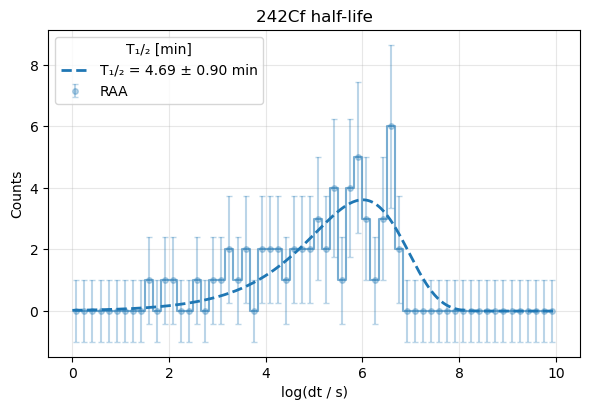

In [29]:
# # Define your list of data‐settings:
cf242 = [
    {
      'df': df_RAA,
      't1_col': 'alpha2_t',
      't2_col': 'alpha1_t',
      'initial': [np.log(2)/(3.5*60), 20],
      'label': 'RAA',
      'linestyle': '--'
    },
#         {
#       'df': df_REAA,
#       't1_col': 'alpha2_t',
#       't2_col': 'alpha1_t',
#       'initial': [np.log(2)/(3.5*60), 20],
#       'label': 'REAA',
#       'linestyle': '--'
#     },

]

fig, ax = plot_multiple_decay_fits(cf242,bins=60,hist_range=(0,10),display_unit='min')
# plt.ylim(0,350)
plt.title("242Cf half-life")
plt.show()
